In [77]:
import re
import json
import requests
import numpy as np

import pandas as pd
#display all rows
pd.set_option('display.max_rows', None)
#display all columns
pd.set_option('display.max_columns', None)

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

from geopy.geocoders import Nominatim

import folium

import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
%matplotlib inline

print('Libraries imported.')

Libraries imported.


In [78]:
df = pd.read_csv('all_india_PO_list_without_APS_offices_ver2_lat_long.csv')

In [79]:
df.isna().sum()

officename                 0
pincode                    0
officeType                 0
Deliverystatus             0
divisionname               0
regionname                 0
circlename                 0
Taluk                   8309
Districtname              36
statename                 36
Telephone             131379
Related Suboffice      29528
Related Headoffice       810
longitude             154655
latitude              154655
dtype: int64

In [80]:
df = df[~df['latitude'].isna()]
df.head()

,officename,pincode,officeType,Deliverystatus,divisionname,regionname,circlename,Taluk,Districtname,statename,Telephone,Related Suboffice,Related Headoffice,longitude,latitude
5154,Prakashamnagar S.O,500016,S.O,Non-Delivery,Secunderabad,Hyderabad City,Andhra Pradesh,Secunderabad,Hyderabad,TELANGANA,040-23463750,NaN,Secunderabad H.O,78.4468,17.4672
52180,Arabic College S.O,560045,S.O,Delivery,Bangalore East,Bangalore HQ,Karnataka,Bangalore North,Bangalore,KARNATAKA,080-25432636,NaN,Bangalore G.P.O.,77.6206,13.0291
52187,Bellandur S.O,560103,S.O,Delivery,Bangalore East,Bangalore HQ,Karnataka,Bangalore South,Bangalore,KARNATAKA,080-28441625,NaN,H.A.L II Stage H.O,77.6760,12.9298
52201,Domlur S.O,560071,S.O,Delivery,Bangalore East,Bangalore HQ,Karnataka,Bangalore North,Bangalore,KARNATAKA,080-25356966,NaN,H.A.L II Stage H.O,77.6359,12.9611
52204,Dr. Shivarama Karanth Nagar S.O,560077,S.O,Delivery,Bangalore East,Bangalore HQ,Karnataka,Bangalore North,Bangalore,KARNATAKA,NaN,NaN,Bangalore G.P.O.,77.6293,13.0681


In [81]:
df_bangalore = df[df['Districtname']=='Bangalore']
df_bangalore = df_bangalore[['officename','longitude','latitude']]
df_bangalore.reset_index(inplace=True,drop=True)
df_bangalore.head()

,officename,longitude,latitude
0,Arabic College S.O,77.6206,13.0291
1,Bellandur S.O,77.6760,12.9298
2,Domlur S.O,77.6359,12.9611
3,Dr. Shivarama Karanth Nagar S.O,77.6293,13.0681
4,Fraser Town S.O,77.6164,13.0005


In [82]:
address = 'Bangalore, Karnataka'

geolocator = Nominatim(user_agent="bangalore_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geographical coordinate of Bangalore,KA are {}, {}.'.format(latitude, longitude))

The geographical coordinate of Bangalore,KA are 12.9791198, 77.5912997.


In [83]:
# create map of Bangalore using latitude and longitude values
bangalore_map = folium.Map(location=[latitude, longitude], zoom_start=11)    

In [84]:
# add neighborhood markers to map

for lat, lng, location in zip(df_bangalore['latitude'], df_bangalore['longitude'], df_bangalore['officename']):
    label = '{}'.format(location)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(bangalore_map)  

bangalore_map

In [85]:
CLIENT_ID = '055Z4N24FVY4ALPQJFJVY4EAZOPGHWE2TSAV5R4TOPBBIPAR'
CLIENT_SECRET = 'JU1TIMBQ34BNXFSRRH3ZCQLYYERDTEBVEAT5XYWN3T2X1TMJ' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

In [86]:
def getNearbyVenues(names, latitudes, longitudes, radius=500, limit=100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            limit)
            
        # make the GET request
        count = 1
        while count != 5:
            try:
                results = requests.get(url).json()["response"]['groups'][0]['items']
                count = 5
            except:
                count += 1
    
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [87]:
bangalore_venues = getNearbyVenues(names = df_bangalore['officename'],
                                 latitudes = df_bangalore['latitude'],
                                 longitudes = df_bangalore['longitude']
                                 )

print(bangalore_venues.shape)
bangalore_venues.head()

(865, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Arabic College S.O,13.0291,77.6206,Fiat Aadya Service Center,13.030655,77.620240,Auto Workshop
1,Arabic College S.O,13.0291,77.6206,D.K Communications,13.027063,77.622548,Electronics Store
2,Arabic College S.O,13.0291,77.6206,Kamal da Dhaba,13.027063,77.622548,Indian Restaurant
3,Arabic College S.O,13.0291,77.6206,New Krishna Sagar,13.026125,77.622722,Indian Restaurant
4,Bellandur S.O,12.9298,77.6760,Kicks On Grass,12.930045,77.679679,Soccer Field


In [88]:
bangalore_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Arabic College S.O,4,4,4,4,4,4
Ashoknagar S.O (Bangalore),9,9,9,9,9,9
B Sk II Stage S.O,5,5,5,5,5,5
Bangalore G.P.O.,12,12,12,12,12,12
Bannerghatta Road S.O,7,7,7,7,7,7
Basavanagudi H.O,23,23,23,23,23,23
Bellandur S.O,19,19,19,19,19,19
Bommanahalli S.O (Bangalore),8,8,8,8,8,8
Bommasandra Industrial Estate S.O,5,5,5,5,5,5


In [89]:
print('There are {} uniques categories.'.format(len(bangalore_venues['Venue Category'].unique())))

There are 149 uniques categories.


In [90]:
# # bangalore_venues_top = bangalore_venues[bangalore_venues['Neighborhood'].isin(df_top.index.tolist())]
# bangalore_venues_top = bangalore_venues
# bangalore_venues_top.head()

In [91]:
bangalore_onehot = pd.get_dummies(bangalore_venues['Venue Category'], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
bangalore_onehot['Neighborhood'] = bangalore_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = bangalore_onehot.columns.tolist()
fixed_columns.insert(0, fixed_columns.pop(fixed_columns.index('Neighborhood')))
bangalore_onehot = bangalore_onehot.reindex(columns = fixed_columns)

print(bangalore_onehot.shape)
bangalore_onehot.head()

(865, 150)


,Neighborhood,ATM,Accessories Store,Afghan Restaurant,Airport Terminal,American Restaurant,Andhra Restaurant,Antique Shop,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Auto Workshop,BBQ Joint,Badminton Court,Bakery,Bar,Basketball Court,Beer Bar,Beer Garden,Bengali Restaurant,Bistro,Bookstore,Boutique,Bowling Alley,Breakfast Spot,Brewery,Bubble Tea Shop,Burger Joint,Bus Line,Bus Station,Bus Stop,Cafeteria,Café,Camera Store,Candy Store,Capitol Building,Chettinad Restaurant,Chinese Restaurant,Chocolate Shop,Clothing Store,Cocktail Bar,Coffee Shop,Convenience Store,Cosmetics Shop,Cricket Ground,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Dog Run,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Farmers Market,Fast Food Restaurant,Financial or Legal Service,Flea Market,Flower Shop,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Garden,Gastropub,Gourmet Shop,Grocery Store,Gym,Gym / Fitness Center,Hookah Bar,Hospital,Hotel,Hotel Bar,Hyderabadi Restaurant,Ice Cream Shop,Indian Restaurant,Indian Sweet Shop,Indie Movie Theater,Intersection,Italian Restaurant,Jewelry Store,Juice Bar,Karnataka Restaurant,Kerala Restaurant,Light Rail Station,Liquor Store,Lounge,Market,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mobile Phone Shop,Motorcycle Shop,Movie Theater,Multicuisine Indian Restaurant,Multiplex,Music Venue,Nightclub,North Indian Restaurant,Office,Paella Restaurant,Pakistani Restaurant,Paper / Office Supplies Store,Park,Performing Arts Venue,Persian Restaurant,Pharmacy,Pizza Place,Playground,Plaza,Pub,Punjabi Restaurant,Resort,Restaurant,Road,Roof Deck,Sandwich Place,Seafood Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Smoke Shop,Snack Place,Soccer Field,South Indian Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Steakhouse,Szechuan Restaurant,Tea Room,Tennis Stadium,Tex-Mex Restaurant,Thai Restaurant,Tibetan Restaurant,Trail,Train Station,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Women's Store,Yoga Studio
0,Arabic College S.O,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Arabic College S.O,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Arabic College S.O,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Arabic College S.O,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Bellandur S.O,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [92]:
bangalore_grouped = bangalore_onehot.groupby('Neighborhood').mean().reset_index()
print(bangalore_grouped.shape)
bangalore_grouped.head()

(56, 150)


,Neighborhood,ATM,Accessories Store,Afghan Restaurant,Airport Terminal,American Restaurant,Andhra Restaurant,Antique Shop,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Auto Workshop,BBQ Joint,Badminton Court,Bakery,Bar,Basketball Court,Beer Bar,Beer Garden,Bengali Restaurant,Bistro,Bookstore,Boutique,Bowling Alley,Breakfast Spot,Brewery,Bubble Tea Shop,Burger Joint,Bus Line,Bus Station,Bus Stop,Cafeteria,Café,Camera Store,Candy Store,Capitol Building,Chettinad Restaurant,Chinese Restaurant,Chocolate Shop,Clothing Store,Cocktail Bar,Coffee Shop,Convenience Store,Cosmetics Shop,Cricket Ground,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Dog Run,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Farmers Market,Fast Food Restaurant,Financial or Legal Service,Flea Market,Flower Shop,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Garden,Gastropub,Gourmet Shop,Grocery Store,Gym,Gym / Fitness Center,Hookah Bar,Hospital,Hotel,Hotel Bar,Hyderabadi Restaurant,Ice Cream Shop,Indian Restaurant,Indian Sweet Shop,Indie Movie Theater,Intersection,Italian Restaurant,Jewelry Store,Juice Bar,Karnataka Restaurant,Kerala Restaurant,Light Rail Station,Liquor Store,Lounge,Market,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mobile Phone Shop,Motorcycle Shop,Movie Theater,Multicuisine Indian Restaurant,Multiplex,Music Venue,Nightclub,North Indian Restaurant,Office,Paella Restaurant,Pakistani Restaurant,Paper / Office Supplies Store,Park,Performing Arts Venue,Persian Restaurant,Pharmacy,Pizza Place,Playground,Plaza,Pub,Punjabi Restaurant,Resort,Restaurant,Road,Roof Deck,Sandwich Place,Seafood Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Smoke Shop,Snack Place,Soccer Field,South Indian Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Steakhouse,Szechuan Restaurant,Tea Room,Tennis Stadium,Tex-Mex Restaurant,Thai Restaurant,Tibetan Restaurant,Trail,Train Station,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Women's Store,Yoga Studio
0,Arabic College S.O,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.25,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.500000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Ashoknagar S.O (Bangalore),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.111111,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.111111,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.111111,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.333333,0.0,0.111111,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.111111,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.111111,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,B Sk II Stage S.O,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.00,0.0,0.2,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.000000,0.0,0.0,0.4,0.000000,0.0,0.000000,0.000000,

In [93]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [94]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create column names according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = bangalore_grouped['Neighborhood']

for ind in np.arange(bangalore_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(bangalore_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Arabic College S.O,Indian Restaurant,Electronics Store,Auto Workshop,Deli / Bodega,Donut Shop,Dog Run,Diner,Dim Sum Restaurant,Dessert Shop,Department Store
1,Ashoknagar S.O (Bangalore),Indian Restaurant,Diner,Park,Breakfast Spot,Convenience Store,Indie Movie Theater,Szechuan Restaurant,Dance Studio,Dim Sum Restaurant,Dessert Shop
2,B Sk II Stage S.O,Ice Cream Shop,Gym,Pizza Place,Fast Food Restaurant,Cupcake Shop,Diner,Dim Sum Restaurant,Dessert Shop,Department Store,Deli / Bodega
3,Bangalore G.P.O.,Indian Restaurant,Café,Chinese Restaurant,Capitol Building,Dance Studio,Bakery,Intersection,Park,Hotel,Fried Chicken Joint
4,Bannerghatta Road S.O,Café,Office,Cafeteria,Indian Restaurant,Sandwich Place,Food Court,Yoga Studio,Dance Studio,Dim Sum Restaurant,Dessert Shop


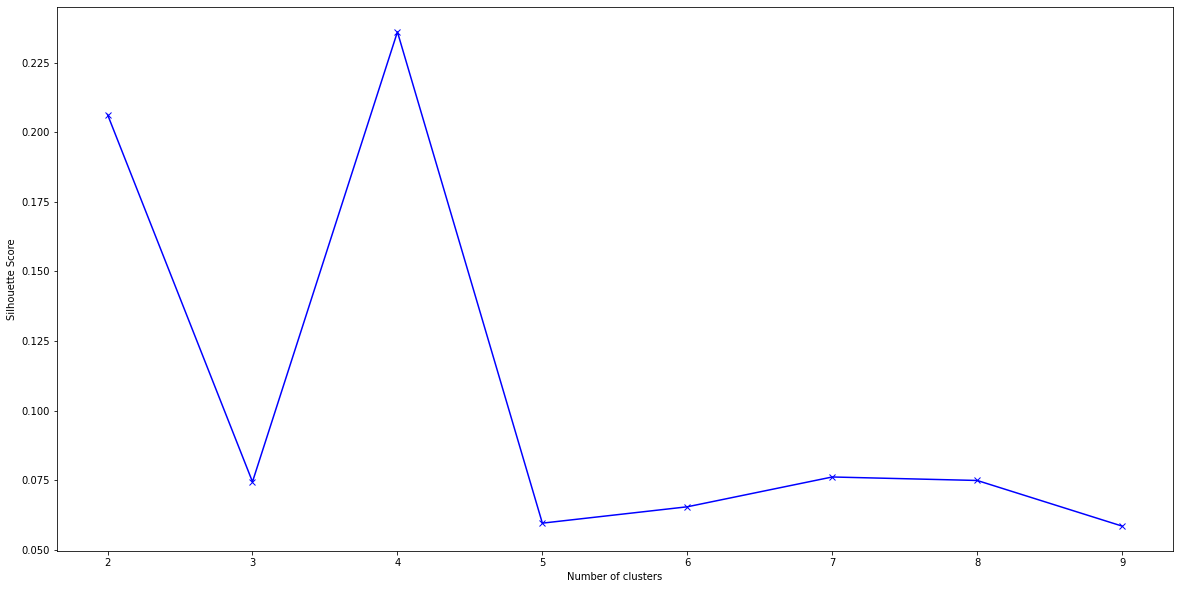

In [95]:
bangalore_grouped_clustering = bangalore_grouped.drop('Neighborhood', 1)

max_score = 10
scores = []

for kclusters in range(2, max_score):
    # Run k-means clustering
    kmeans = KMeans(n_clusters = kclusters, init = 'k-means++', random_state = 0).fit_predict(bangalore_grouped_clustering)
    
    # Gets the silhouette score
    score = silhouette_score(bangalore_grouped_clustering, kmeans)
    scores.append(score)

plt.figure(figsize=(20,10))
plt.plot(np.arange(2, max_score), scores, 'bx-')
plt.xlabel("Number of clusters")
plt.ylabel("Silhouette Score")
plt.xticks(np.arange(2, max_score))
plt.show()

In [96]:
# select best number of clusters
kclusters = 8

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(bangalore_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([1, 1, 2, 1, 2, 1, 2, 1, 1, 1], dtype=int32)

In [97]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

bangalore_merged = bangalore_venues[bangalore_venues.columns[0:3]].drop_duplicates()
bangalore_merged.reset_index(drop = True, inplace = True)

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
bangalore_merged = bangalore_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

bangalore_merged.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Arabic College S.O,13.0291,77.6206,1,Indian Restaurant,Electronics Store,Auto Workshop,Deli / Bodega,Donut Shop,Dog Run,Diner,Dim Sum Restaurant,Dessert Shop,Department Store
1,Bellandur S.O,12.9298,77.6760,2,Fast Food Restaurant,Indian Restaurant,Grocery Store,Badminton Court,Multiplex,Café,Pizza Place,Punjabi Restaurant,Restaurant,Shopping Mall
2,Domlur S.O,12.9611,77.6359,1,Indian Restaurant,Pizza Place,Café,Yoga Studio,Cupcake Shop,Diner,Dim Sum Restaurant,Dessert Shop,Department Store,Deli / Bodega
3,Dr. Shivarama Karanth Nagar S.O,13.0681,77.6293,1,ATM,Kerala Restaurant,Andhra Restaurant,Indian Restaurant,Asian Restaurant,Deli / Bodega,Donut Shop,Dog Run,Diner,Dim Sum Restaurant
4,Fraser Town S.O,13.0005,77.6164,1,Indian Restaurant,Bakery,Ice Cream Shop,Chinese Restaurant,Middle Eastern Restaurant,Fast Food Restaurant,Tea Room,BBQ Joint,Department Store,Mediterranean Restaurant


In [98]:
# create map
bangalore_clusters_map = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
colors_array = cm.rainbow(np.linspace(0, 1, kclusters))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(bangalore_merged['Neighborhood Latitude'], bangalore_merged['Neighborhood Longitude'], bangalore_merged['Neighborhood'], bangalore_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster+1), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(bangalore_clusters_map)
       
bangalore_clusters_map